# DeepMind Paper Implementation

- delete models
- huggingface-cli delete-cache

- Models used 124M, 774M: [https://huggingface.co/MBZUAI/LaMini-GPT-124M]
- 

In [317]:
import torch
import sentencepiece
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import time
from typing import Tuple
import pandas as pd
import matplotlib.pyplot as plt

In [318]:
checkpoint_draft = "MBZUAI/LaMini-GPT-124M" 
checkpoint_target = "MBZUAI/LaMini-GPT-774M"
# draft_model = pipeline('text-generation', model = checkpoint_draft)
# target_model = pipeline('text-generation', model = checkpoint_target)
draft_model = AutoModelForCausalLM.from_pretrained(checkpoint_draft).to(device)
target_model = AutoModelForCausalLM.from_pretrained(checkpoint_target).to(device)

## Algorithm 1: ArS

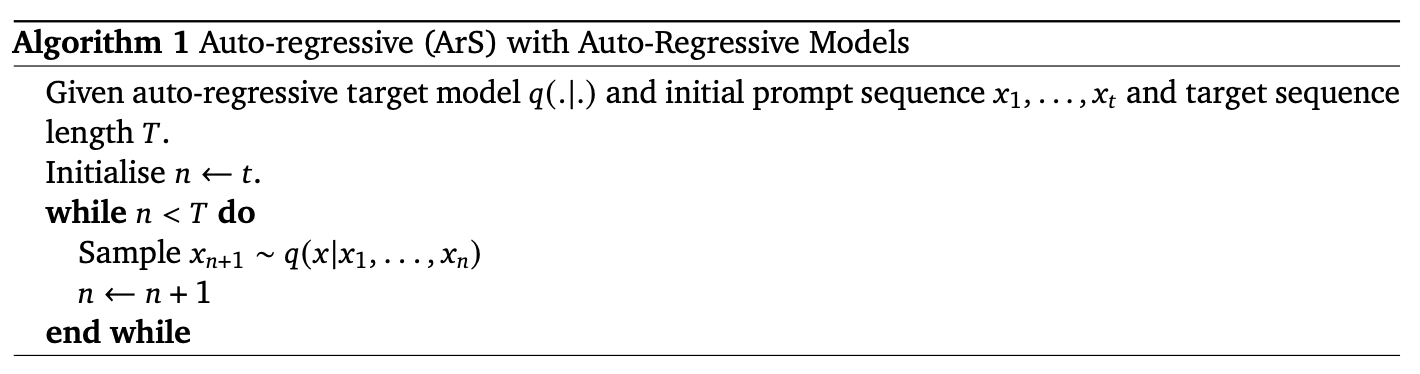

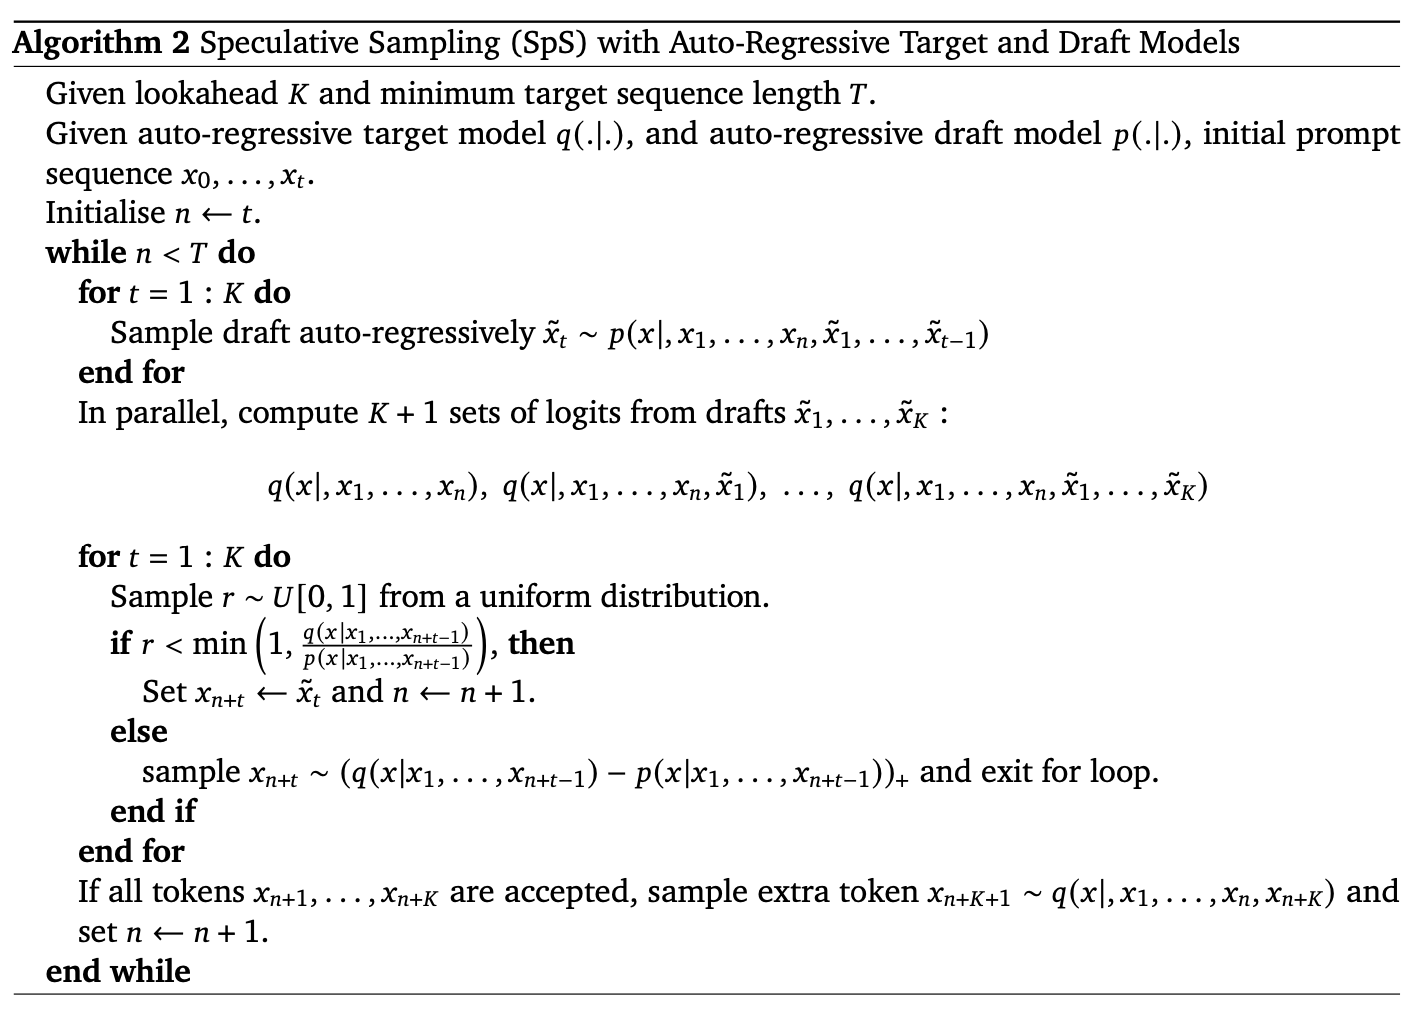

In [319]:
# helper function to get the logits of the next token
def model_fn(model, input_ids, temperature=0.5, max_length=5):
    temperature = temperature + 1e-8
    output = model.generate(input_ids, do_sample=True, temperature=temperature,
                            return_dict_in_generate=True, output_scores=True, 
                            pad_token_id = 50256 )
    # generated_text = tokenizer.decode(output.sequences[0], skip_special_tokens=True)
    logits = output.scores[-1][0]  # Last token's logits
    return F.softmax(logits, dim=-1) 

In [320]:
def sampling(p):
    output = torch.multinomial(p, 1)
    return output.reshape(1,-1)

' x is the tokenized prompt, max_new_tokens = N'
def autoregressive_generation(x, model, max_new_tokens):
    n = len(x)
    N = max_new_tokens
    T = len(x) + N
    while n<T:
        logits = model_fn(model,x)
        output = sampling(logits)
        x = torch.cat((x, output), dim=-1)
        n += 1
    return x

In [321]:
def max_fn(x): # (f)_+ function in the paper
    x_max = torch.where(x > 0, x, 0)
    return x_max / torch.sum(x_max)

In [322]:
def speculative_sampling(x, draft_model, target_model, lookahead_k, max_new_tokens):
    '''p: draft model, q: target model, x: tokenized prompt, K: lookahead_k, N: max_new_tokens'''
    n = len(x[0])
    N = max_new_tokens
    K = lookahead_k
    T = n + N
    # print('initial', n)
    while n<T:
        x_draft = x
        for t in range(K): # sample draft-auto-regressively \hat{x}_{(t)}
            p = model_fn(draft_model, x_draft)
            x_draft =torch.cat((x_draft, sampling(p)), dim =-1)
        # in parallel, compute K+1 logits from the draft \hat{x}_i (i=1,..K)
        
        q = model_fn(target_model, x_draft)
        # add drafted tokens based on rejection algorithm and then resample
        acceptance = True
        for t in range(K):
            r = np.random.random()
            i = n - 1
            drafted_token_t = x_draft[0][i+1].reshape(1,-1)
            num = q[drafted_token_t]
            den = p[drafted_token_t]
        
            if r < min(1, num/den):
                x = torch.cat((x, drafted_token_t), dim=-1)
                n += 1
            else:
                new_sample = sampling(max_fn(q - p))
                x = torch.cat((x, new_sample), dim=-1)
                n += 1
                acceptance = False
                break
        # if all accepted, sample x_{n+K+1} from target model
        if acceptance:
            x = torch.cat((x, sampling(q)), dim=-1)
            n += 1
        assert( n == len(x[0])), f'{n} {len(x[0])}'
    # print(n, T)
    return x

In [323]:
def sampling_test(prompt:str, tokenizer, sampling:str, target_model, draft_model=None, max_new_tokens=50, lookahead_k=2)-> Tuple[str, float]:
   
    tokenized_input = tokenizer.encode(prompt, return_tensors='pt').to(device)
    # print('Given Input:', tokenizer.decode(tokenized_input[0],skip_special_tokens=True))

    if sampling == 'autoregressive':
        start = time.time()
        output_ar = autoregressive_generation(model = target_model, x= tokenized_input, max_new_tokens=max_new_tokens)
        end = time.time()
        generated_text = tokenizer.decode(output_ar[0])
        time_taken = end - start

    elif sampling == 'speculative':
        start = time.time()
        output_sp = speculative_sampling(x=tokenized_input, draft_model=draft_model, target_model=target_model, lookahead_k=lookahead_k, max_new_tokens=max_new_tokens)
        end = time.time()
        generated_text = tokenizer.decode(output_sp[0])
        time_taken = end - start
    else:
        raise ValueError('sampling must be either autoregressive or speculative')
    return generated_text, time_taken


In [324]:
prompt = "In a shocking finding, "
tokenizer = AutoTokenizer.from_pretrained(checkpoint_target,padding_side='right')
# tokenizer.padding_side = 'left'

In [327]:
# Autoregressive sampling
output_ar, time_ar = sampling_test(prompt, tokenizer, 'autoregressive', target_model, draft_model, max_new_tokens=12)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [328]:
print('Generated Text:', output_ar)
print('Time taken:', time_ar)

Generated Text: In a shocking finding,, is years new short<|endoftext|> of of second



Time taken: 13.497381210327148


In [329]:
# Autoregressive sampling
output_sp, time_sp = sampling_test(prompt, tokenizer, 'speculative', target_model, draft_model, max_new_tokens=12, lookahead_k=4)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 20, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 21, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(


In [330]:
print('Generated Text:', output_sp)
print('Time taken:', time_sp)

Generated Text: In a shocking finding,  in costs. $ We expenses<|endoftext|> cannot on cannot be
on can

Time taken: 5.758047819137573


Source: [https://jaykmody.com/blog/speculative-sampling/]

# Time Analysis

In [303]:
temperature = 0
max_lengths = [20, 50, 100]  # example max_lengths
lookahead_ks = np.linspace(3, max_lengths[-1] // 2, 4, dtype=int)  # Generate 5 k values between 2 and max_length//2

# Store the results
results = []
sampling_test(prompt, tokenizer, 'speculative', target_model, draft_model, max_new_tokens=12, lookahead_k=4)

# Loop over different max_length and k values
for max_length in max_lengths:
    # Run autoregressive sampling
    output_ar, time_ar = sampling_test(prompt, tokenizer, 'autoregressive', target_model, draft_model, max_new_tokens=max_length)
    results.append(['autoregressive', max_length, 0, time_ar, output_ar])
    
    for k in lookahead_ks:
        if k > max_length // 2:
            continue

        # Run speculative sampling
        output_sp, time_sp = sampling_test(prompt, tokenizer, 'speculative', target_model, draft_model, max_new_tokens=max_length, lookahead_k=k)

        results.append(['speculative', max_length, k, time_sp, output_sp])
# Create a DataFrame
df = pd.DataFrame(results, columns=['Sampling Method', 'Max Length', 'K Values', 'Time Taken', 'Text Generated'])

# Save the results to a CSV file
csv_file_path = f'sampling-times-temp{temperature}.csv'
df.to_csv(csv_file_path, index=False)

A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 22, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 23, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 24, but `max_length` is set to 20. This can lead to unexpected 

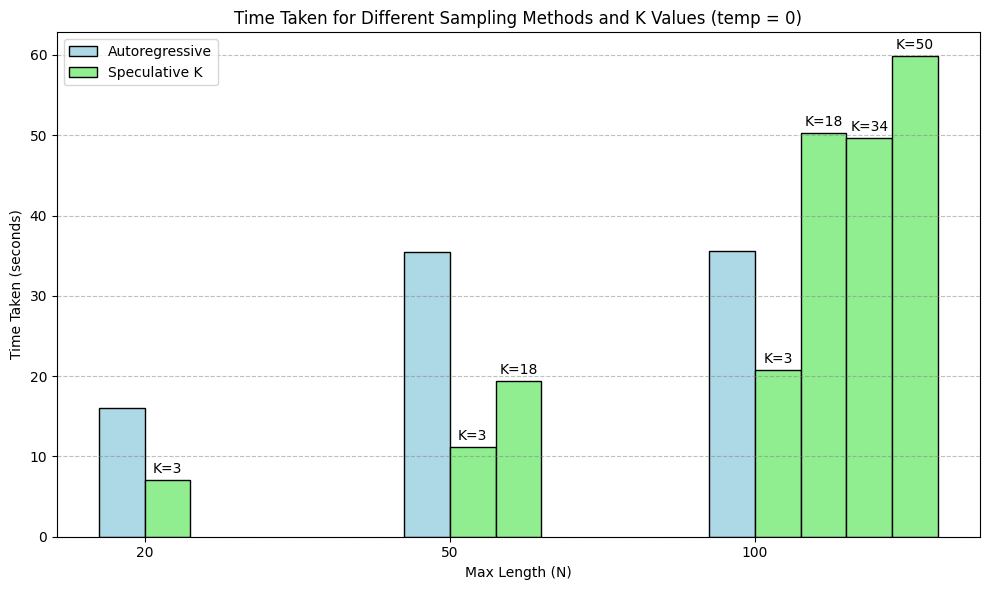

<Figure size 640x480 with 0 Axes>

In [309]:
# Adjust the plot aesthetics as per the user's request
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color for the bars
color_speculative = 'lightgreen'  # A more pleasant color for speculative bars
color_autoregressive = 'lightblue'  # A more pleasant color for autoregressive bars

# Iterate over max_lengths and k_values to create bar positions
for i, max_length in enumerate(max_lengths_sorted):
    # Select subset of DataFrame for the current N (Max Length)
    subset = df[df['Max Length'] == max_length]
    
    # Plot bars for autoregressive method
    autoregressive_time = subset[subset['Sampling Method'] == 'autoregressive']['Time Taken'].values
    if autoregressive_time.size > 0:
        ax.bar(ind[i] - bar_width/2, autoregressive_time, bar_width, label='Autoregressive' if i == 0 else "", 
               color=color_autoregressive, edgecolor='black')
    
    # Plot bars for speculative method with different K values
    speculative_subset = subset[subset['Sampling Method'] == 'speculative']
    for j, k_value in enumerate(speculative_subset['K Values']):
        time = speculative_subset[speculative_subset['K Values'] == k_value]['Time Taken'].values
        if time.size > 0:
            bar = ax.bar(ind[i] + (j+0.5)*bar_width, time, bar_width, label=f'Speculative K' if i == 0 else "", 
                         color=color_speculative, edgecolor='black')
            # Annotate K value on the bar
            ax.annotate(f'K={k_value}',
                        xy=(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# Add grid to the plot with reduced alpha for less bold lines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Set the labels and legend
ax.set_xticks(ind)
ax.set_xticklabels(max_lengths_sorted)
ax.set_xlabel('Max Length (N)')
ax.set_ylabel('Time Taken (seconds)')
ax.set_title(f'Time Taken for Different Sampling Methods and K Values (temp = {temperature})')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot to a file
plot_file_path = f'sampling-times-temp{temperature}.png'
plt.savefig(plot_file_path)

In [331]:
temperature = 0.5
max_lengths = [20, 50, 100]  # example max_lengths
lookahead_ks = np.linspace(3, max_lengths[-1] // 2, 4, dtype=int)  # Generate 5 k values between 2 and max_length//2

# Store the results
results = []
sampling_test(prompt, tokenizer, 'speculative', target_model, draft_model, max_new_tokens=12, lookahead_k=4)

# Loop over different max_length and k values
for max_length in max_lengths:
    # Run autoregressive sampling
    output_ar, time_ar = sampling_test(prompt, tokenizer, 'autoregressive', target_model, draft_model, max_new_tokens=max_length)
    results.append(['autoregressive', max_length, 0, time_ar, output_ar])
    
    for k in lookahead_ks:
        if k > max_length // 2:
            continue

        # Run speculative sampling
        output_sp, time_sp = sampling_test(prompt, tokenizer, 'speculative', target_model, draft_model, max_new_tokens=max_length, lookahead_k=k)

        results.append(['speculative', max_length, k, time_sp, output_sp])
# Create a DataFrame
df = pd.DataFrame(results, columns=['Sampling Method', 'Max Length', 'K Values', 'Time Taken', 'Text Generated'])

# Save the results to a CSV file
csv_file_path = f'sampling-times-temp{temperature}.csv'
df.to_csv(csv_file_path, index=False)

/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 22, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 23, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/transformers/generation/utils.py:1141: UserWarning: Input length of input_ids is 24, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
/Users/vashisth/anaconda3/envs/speculative_decoding/lib/python3.11/site-packages/transformers/gen

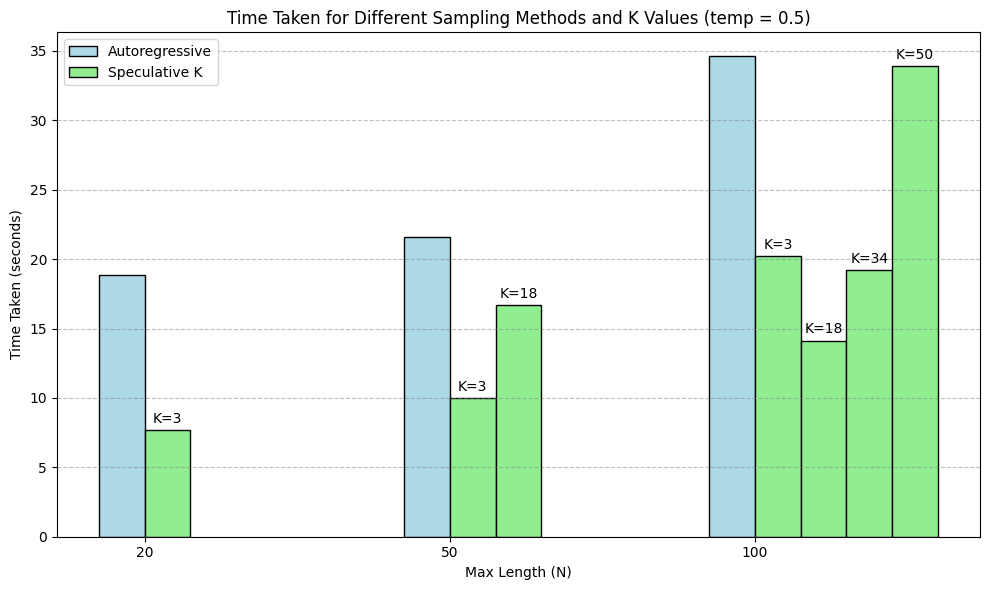

<Figure size 640x480 with 0 Axes>

In [333]:
# Adjust the plot aesthetics as per the user's request
fig, ax = plt.subplots(figsize=(10, 6))

# Set the color for the bars
color_speculative = 'lightgreen'  # A more pleasant color for speculative bars
color_autoregressive = 'lightblue'  # A more pleasant color for autoregressive bars

# Iterate over max_lengths and k_values to create bar positions
for i, max_length in enumerate(max_lengths_sorted):
    # Select subset of DataFrame for the current N (Max Length)
    subset = df[df['Max Length'] == max_length]
    
    # Plot bars for autoregressive method
    autoregressive_time = subset[subset['Sampling Method'] == 'autoregressive']['Time Taken'].values
    if autoregressive_time.size > 0:
        ax.bar(ind[i] - bar_width/2, autoregressive_time, bar_width, label='Autoregressive' if i == 0 else "", 
               color=color_autoregressive, edgecolor='black')
    
    # Plot bars for speculative method with different K values
    speculative_subset = subset[subset['Sampling Method'] == 'speculative']
    for j, k_value in enumerate(speculative_subset['K Values']):
        time = speculative_subset[speculative_subset['K Values'] == k_value]['Time Taken'].values
        if time.size > 0:
            bar = ax.bar(ind[i] + (j+0.5)*bar_width, time, bar_width, label=f'Speculative K' if i == 0 else "", 
                         color=color_speculative, edgecolor='black')
            # Annotate K value on the bar
            ax.annotate(f'K={k_value}',
                        xy=(bar[0].get_x() + bar[0].get_width() / 2, bar[0].get_height()),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

# Add grid to the plot with reduced alpha for less bold lines
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# Set the labels and legend
ax.set_xticks(ind)
ax.set_xticklabels(max_lengths_sorted)
ax.set_xlabel('Max Length (N)')
ax.set_ylabel('Time Taken (seconds)')
ax.set_title(f'Time Taken for Different Sampling Methods and K Values (temp = {temperature})')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot to a file
plot_file_path = f'sampling-times-temp{temperature}.png'
plt.savefig(plot_file_path)

torch